# Intrusion of Personal Space as a Cause for Violence: An Inverse Reinforcement Learning Problem on Laboratory Mice-  Supplementary Material A
*Oğul Can Yurdakul, 2233047*

In [1]:
import pandas as pd
import scipy.signal as sg
from scipy.ndimage import median_filter 
import numpy as np
import os
import json
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sb

## Data Download

This code snippets are taken from [Loading_CalMS21_data](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/behavior/Loading_CalMS21_data.ipynb#scrollTo=Z-GXdCbsbkIb), provided by [Neuromatch Academy Computation Neuroscience Summer School](https://compneuro.neuromatch.io/tutorials/intro.html)

In [2]:
urllib.request.urlretrieve('https://data.caltech.edu/tindfiles/serve/a86f4297-a087-4f40-9ed4-765779105c2c/', 'task1.zip')
urllib.request.urlretrieve('https://data.caltech.edu/tindfiles/serve/ca84a583-ea06-440a-995c-c184bcb0291c/', 'calms21_convert_to_npy.py')
!unzip task1.zip

Archive:  task1.zip
   creating: task1_classic_classification/
  inflating: task1_classic_classification/taskprog_features_task1_train.json  
  inflating: task1_classic_classification/calms21_task1_test.json  
  inflating: task1_classic_classification/taskprog_features_task1_test.json  
  inflating: task1_classic_classification/calms21_task1_train.json  


In [3]:
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.' --parse_treba

tcmalloc: large alloc 1224941568 bytes == 0x5591f8e1a000 @  0x7f04c5a5d1e7 0x5591f5cabf98 0x5591f5c76e27 0x5591f5df5115 0x5591f5d8f888 0x5591f5c7a6f2 0x5591f5d58c6e 0x5591f5d8f802 0x5591f5c7a6f2 0x5591f5c7d926 0x5591f5df87a3 0x5591f5c7a349 0x5591f5d6be1d 0x5591f5cede99 0x5591f5ce8ced 0x5591f5c7bbda 0x5591f5cedd00 0x5591f5ce89ee 0x5591f5c7bbda 0x5591f5ce9915 0x5591f5c7bafa 0x5591f5ce9915 0x5591f5ce89ee 0x5591f5ce86f3 0x5591f5db24c2 0x5591f5db283d 0x5591f5db26e6 0x5591f5d8a163 0x5591f5d89e0c 0x7f04c4847bf7 0x5591f5d89cea
tcmalloc: large alloc 1224941568 bytes == 0x559241e4c000 @  0x7f04c5a5d1e7 0x5591f5cabf98 0x5591f5cc14ec 0x5591f5d4ee93 0x5591f5c7a349 0x5591f5c7a240 0x5591f5cee0f3 0x5591f5ce89ee 0x5591f5c7c271 0x5591f5c7b720 0x5591f5c7d698 0x5591f5d5a441 0x5591f5df87d1 0x5591f5c7a349 0x5591f5d6be1d 0x5591f5cede99 0x5591f5ce8ced 0x5591f5c7bbda 0x5591f5cedd00 0x5591f5ce89ee 0x5591f5c7bbda 0x5591f5ce9915 0x5591f5c7bafa 0x5591f5ce9915 0x5591f5ce89ee 0x5591f5ce86f3 0x5591f5db24c2 0x5591f5db

In [4]:
import numpy as np

def load_task1_data(data_path):
    """ 
    Load data for task 1:
        The vocaubulary tells you how to map behavior names to class ids;
        it is the same for all sequences in this dataset.
    """
    data_dict = np.load(data_path, allow_pickle=True).item()
    dataset = data_dict['annotator-id_0']
    # Get any sequence key.
    sequence_id = list(data_dict['annotator-id_0'].keys())[0]
    vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
    return dataset, vocabulary


In [5]:
training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')
keys = list(training_data.keys())

## Processing Data for WebPPL Import

Creating the dictionary to encode actions as strings.

In [6]:
inverseVocab = dict(zip(vocab.values(), vocab.keys()))
inverseVocab[3] = 'none'
inverseVocab

{0: 'attack', 1: 'investigation', 2: 'mount', 3: 'none'}

Extract the actions observed and the chosen states from the dataset. Apply median filtering to reduce the noise. Choose training data 5.

In [26]:
experimentIndex = 5
thisExperiment = training_data[keys[experimentIndex]]

dT = 1/30
medfiltN = 7

actionIndices = thisExperiment['annotations'][:] # I will have to decide what to take this

residentNoseLocations = median_filter(thisExperiment['keypoints'][:, 0, :, 0], 
                                      size=(7,1),
                                      mode='nearest')
intruderNoseLocations = median_filter(thisExperiment['keypoints'][:, 1, :, 0], 
                                      size=(7,1),
                                      mode='nearest')
residentNeckLocations = median_filter(thisExperiment['keypoints'][:, 0, :, 3], 
                                      size=(7,1),
                                      mode='nearest')
intruderNeckLocations = median_filter(thisExperiment['keypoints'][:, 1, :, 3], 
                                      size=(7,1),
                                      mode='nearest')

residentHeadVector = residentNoseLocations - residentNeckLocations
intruderHeadVector = intruderNoseLocations - intruderNeckLocations

noseDistance = np.linalg.norm(residentNoseLocations - intruderNoseLocations, axis=1)
noseDistance /= (1024**2 + 570**2)**0.5

noseVelocity = np.diff(noseDistance) / dT

headAngles = np.zeros(residentHeadVector.shape[0])

for t in range(len(headAngles)):
    dot = np.dot(residentHeadVector[t], intruderHeadVector[t])
    norm1 = np.linalg.norm(residentHeadVector[t])
    norm2 = np.linalg.norm(intruderHeadVector[t])
    headAngles[t] = dot / (norm1 * norm2)

Visualize the extracted states.

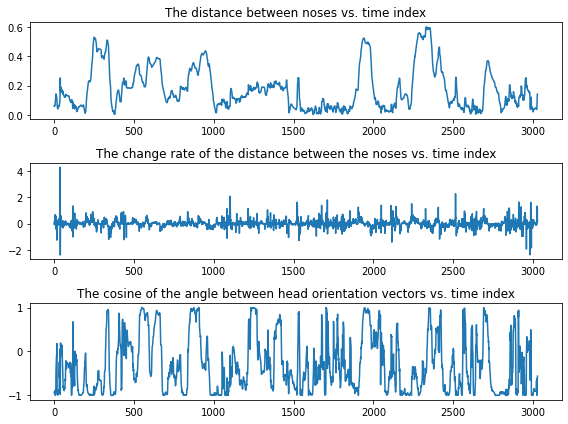

In [27]:
fig, axs = plt.subplots(3, figsize=(8,6))

axs[0].plot(noseDistance)
axs[0].set_title('The distance between noses vs. time index')

axs[1].plot(noseVelocity)
axs[1].set_title('The change rate of the distance between the noses vs. time index')

axs[2].plot(headAngles)
axs[2].set_title('The cosine of the angle between head orientation vectors vs. time index')
plt.tight_layout()

Visualize the actions taken at each time index.

Text(0.5, 1.0, 'The action label at each time index')

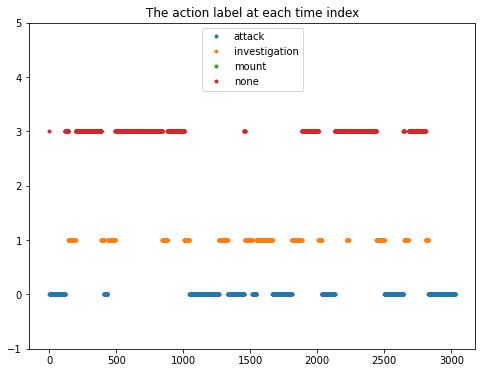

In [28]:
plt.figure(figsize=(8,6))
idx = np.arange(len(actionIndices))
for i in range(4):
    plt.plot(idx[actionIndices == i], actionIndices[actionIndices == i], '.', label=inverseVocab[i])
plt.legend(loc = 'upper center')
plt.ylim(-1, 5)
plt.title('The action label at each time index')

Create a dictionary containing the state vectors as an array and actions as strings and export it.

In [30]:
observationDictionary = {}

for t in range(len(actionIndices)-1):
    observationDictionary[t] = {'state': [noseDistance[t], noseVelocity[t], headAngles[t]],
                                'action': inverseVocab[actionIndices[t]]}

target = open('bigData.json', mode='w')

json.dump(observationDictionary, target)

## Analysis of Results

Import the results as printed in WebPPL and visualize them using violin plots.

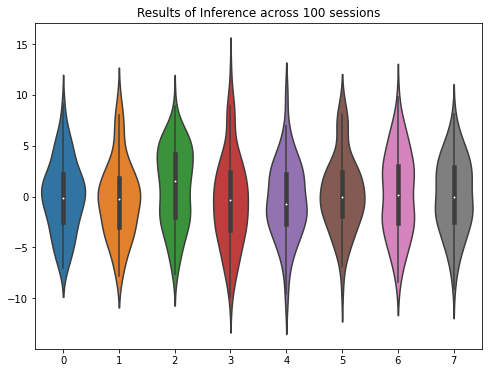

In [31]:
results = np.array([[-5.011511836292504,-7.445105277988934,0.8123658240062978,-8.840462945379203,-10.481233015155492,-4.076396045431149,2.579698890108144,-4.610602344561652],[-4.140384604078859,-2.90205444074837,2.0443638728084195,3.7922621035042865,-3.9286021876165207,-1.7798299299840825,-6.660978113788227,5.175414597521467],[-0.4862239164853578,0.04466104578636226,-2.591455070905016,0.3803941551950993,-4.079465312593746,-4.452173575037761,7.56209664097597,0.130528906649865],[1.2297769241072127,-5.5227382526403925,-5.335997575311276,-2.74173596327597,-1.2270174553002526,-1.2552548145100935,1.6084712660210299,5.0092114466703626],[0.22307951995779668,1.179119640115145,3.6864880568490728,-9.842107262882452,-1.4837611463578735,9.100070680439078,-5.9308817903404485,1.7989565878326803],[-0.08417900008779146,3.1856558062860203,-3.1484959506301324,2.410102460881298,-2.357442997019747,1.1244015300749768,2.382373992548247,0.8277210290753197],[1.5559468939012935,7.120420041072059,1.7838758604468363,12.10505286614644,3.961902481374702,-0.658484383432094,-5.6914588512171616,-2.587353005914695],[-2.0599806314579125,-6.10742903577094,4.583061260129575,-7.3150774587168925,4.268473112689868,-0.07967497070290376,3.0013194121705395,-1.1519364495527293],[-2.5170804740330404,0.4921254391482907,0.029793392611251763,3.047941840545344,-2.811312523915856,7.416578793068288,-6.223272511333679,6.421083815363632],[-3.2771358401455633,-1.2783214947924326,4.861736992263941,-2.549313407636828,1.0157837586101206,-0.37913257365834174,-2.388395306243761,-0.8205278838391488],[2.1661807806424767,-0.1929714731776201,5.822800826178908,-1.9770204081201772,1.171045262534832,-5.482545466394648,-0.6173324109920739,-2.250450795287151],[1.3411707984125898,3.5657072270802015,-1.8635005311054587,2.9176511574460076,-7.145443888521989,-2.566632924298378,-5.710810313772189,0.12300974364994975],[-6.169058512378694,-3.2034871195297354,6.1633932510402,-5.761232027178745,3.9499178908424954,-0.6684398752181934,2.073376268804858,3.4284164480528503],[2.473291142892912,2.876139451909787,3.557032019565462,-2.3071015667889494,6.165143693127285,5.602188532178683,-2.5967928097889375,-1.3995779272650044],[-4.5145131373322105,-2.2239103204064308,8.885945835362874,8.355514835241472,1.948129481102974,0.9935040441895268,-4.6315319418366645,-1.6416253316620268],[-5.234967417299711,-2.7797340272896034,6.214452822715402,4.116443444421196,2.084929344924688,-0.35707115999529615,0.32870873977823556,-1.3407703180213082],[-4.502645856387484,-0.26983341444022707,-1.9620510312191874,-2.1766280174013257,-0.8597503945108259,-0.08705783681310138,1.4209743547584939,-6.532384626143244],[-0.8676642874800533,0.31837423217619315,6.592286688913785,3.695949533226613,-1.644127641365751,1.3025155173782512,-2.7105857509324274,-3.8972957829102555],[2.8041996514534855,1.47552414963127,-4.401564831842577,-3.185409016521237,-2.6700540490216893,3.2606449034175187,-1.9836752794930843,-0.9683482046085315],[4.587260333959013,8.029567032104117,-0.42329636945114674,-5.62739273625581,-1.1912026799777424,-9.34682243509282,-4.687172653931251,-2.4331146321840222],[8.071619768345302,-4.016916323859084,6.694652868326041,-6.172808820558897,-2.579422935930629,-0.6893139214977245,4.579151736089239,2.352692684639404],[5.33733939948332,7.445030798774288,-2.4792114233883162,-1.0693819557853363,4.3097983205406685,-2.087166840315987,-2.1729640144588687,-1.122473606215704],[1.22321262460474,-0.8774864944115717,2.9172021305471363,1.0127512560645895,-6.648280635991861,2.591057101282572,-0.49764139791745104,1.4997793774498662],[-2.5457389001512802,-1.1035507145842536,3.800928299322246,-2.184813770768041,1.2801950308604149,1.2869561749450886,3.152442677949847,-4.357067272544658],[1.262812381912278,5.349152826144678,5.080606122466499,8.787678835356031,3.5148570134287067,2.9699501962112067,5.8678770048809294,3.659229600175324],[0.7065437943094721,-1.3004794204914452,-1.4906885176951044,-1.902964349860506,2.6178505715558935,-1.6606377984192848,9.785182311885308,-0.8182633264594621],[4.413545217425135,-0.8127423152504643,-4.787549565114362,-6.825422769509772,-2.0570541168738377,2.9006494885471272,-2.8035361311764824,-2.552788919040052],[-1.693849717992903,-5.1703413028681044,4.836236278537432,3.654707060990812,0.6021010414709171,-4.170456425047827,2.9659215152964484,0.5608031521989321],[-2.779886116412784,1.5454599975777166,-1.724684232452341,4.001474148204419,2.509936036499885,-3.915835533546067,1.9348177695454587,-0.22619613950224787],[-0.25844213705779234,3.5060611675838116,3.187229720043918,-3.56731347486776,-3.3621733097178206,7.587664464486117,-1.2397950424214772,0.03905938025354552],[4.112205794332458,-2.6399700698038604,1.1783422540526167,3.1541599076657123,-4.058176743867502,-1.1979079933822672,3.53665085435027,2.264631974225629],[-4.8614418666137595,-3.667910140762936,3.6297100441881134,-3.366635719536448,0.9154298417398289,-1.0788118598211007,-3.4394110550533106,3.3656662263036687],[-0.7736596427671285,9.001663323198336,1.640136336850944,-4.61424660872158,-1.0654928524546123,-4.849013091347658,3.881754674470409,2.886704861304555],[1.078147115502331,0.36417325756927765,4.9617143618702375,-0.7265259169181763,-3.156853468126056,2.194471425507713,1.6715060346746542,4.096692055100143],[-0.15680521933895641,-0.5099055864106432,-1.869332626523936,-0.1029382314558451,3.9915114243298326,-2.563716355906652,1.389375949941034,-3.2404978250217993],[-7.008859226663124,-4.7586855685779845,2.284778644001,0.7573976158548278,0.3991528896115633,-2.657349305846575,-3.5247516513319384,2.041220799852309],[-6.340641306197445,-3.371606855879395,6.639006086343665,-5.810818997820999,0.9009388157876911,-1.9286621663464751,-7.231655130553066,-3.356894700725934],[-0.5173450487182074,-0.0020672448534261685,-7.657217699591505,-3.526482741642088,-1.4650935195930852,1.1203610070609198,-5.149492702161154,6.321801361294441],[-0.1302727696091189,7.731525287015341,1.5463869514389394,5.512513204424012,-1.59605512696272,-0.7885446283309114,4.947042800986745,0.5719522270606687],[-0.5422364559020036,-7.018077562983272,5.223922170916385,-6.025860544647497,2.8725004443486784,9.039254762579768,2.7816451037925694,-3.567162644882272],[-3.8185216412875684,2.444311033849591,-0.6152301525454531,-2.112002404307741,10.138616863830364,1.1448670881945435,-4.170762978555656,-2.3093939652736855],[5.872410337466749,-0.9189881116512733,-2.9094248035316324,0.8610290649331295,1.0297346018889018,-1.1518493543892159,5.475785606669333,3.5570893951401055],[-0.22758573429162868,-2.864136570653668,4.518927756681675,-2.692399362719242,-1.3092624922362361,-4.11081706601561,0.4991410995064621,8.154211277361997],[-2.861255498654667,1.0253196752460778,6.2881731093618844,-6.2165632844085215,-2.725301648153371,-2.975952414727153,5.844471518577466,-0.6187783823399291],[3.1154299863479387,5.5513062246457565,-0.8950006687417369,-5.845866027397742,-0.9725106685730837,2.32635023172248,5.962011383843928,3.102432745090771],[-3.8731930992571395,6.2072005471335086,2.293641848101956,7.859595401858995,2.2084026529408165,3.2636217283220845,4.537325727197172,3.233313010711473],[-2.0754194706930824,-1.5130643751144943,-6.375940740586736,-2.2637454081857493,2.9290766718244448,1.1542264827795026,2.4481423175640047,-4.9759749156477735],[-1.5454312230890863,-2.25654914611557,3.688240053124311,8.951702688002698,-0.05081487137977507,-4.349450486734799,-3.2330971725874167,-2.196364287769855],[4.3428146249434985,2.2224555114031164,-0.5526238351367722,0.884778622192246,-9.572107872093397,-0.022227068154835418,-5.8625111700556385,2.02971219162682],[2.057796083370266,-3.0187798310776133,-5.202445672314713,0.3052111019781664,1.70733495173907,-3.372767142204098,4.143744672238935,-2.53194317497263],[-4.381435746004678,-3.368309337803928,-0.25296699972178505,7.082727930564479,2.376095081761214,7.371745896026876,0.9997121515378264,3.6003385901666403],[4.366495794125895,2.6119451751786507,-1.7444522574433057,-5.166629483200372,-0.47759742815881245,1.6142935542929384,2.90160168622301,-7.398101501010345],[-2.3543677265017284,-0.3675130515439162,4.524532101094577,7.900746684533457,-6.570840408004576,0.9574571652550665,-0.23091365816805776,4.973388871464949],[1.4713100811925703,0.021006785980413795,-2.223918455114321,-4.195139966347118,-3.0605667674753954,5.772624635137499,4.3194556808276365,-1.8831169917122097],[-6.916481413051744,4.060451252340619,-5.850793801261322,-0.17851832005205967,-2.4064362019284364,2.409031719502131,-2.334367228186321,2.100848115500866],[3.7891336245495215,-4.322134643507675,2.322733143747371,3.085353155548071,6.972985670112585,8.079821174415972,-4.872417738322878,-5.123790788720897],[-2.2379160064604884,1.6285178047643145,-4.201297139437887,0.21391394240841557,-1.6595746937698255,6.397843124799698,4.943708841460729,-2.8190541174118233],[-1.0097475136817493,5.819952152157973,4.1473048382650965,1.347746992288103,-1.1681560637526194,0.6423883548321321,-1.162196297605411,4.87922102235464],[2.013781143702911,-6.018385619341236,4.822462765482703,1.0296311042764963,-3.360243032712335,-1.42646493206915,-0.4436805389086309,-0.7878546209498856],[0.8580074541254007,3.371631184577865,1.1790699325146567,1.87159845733141,-5.182729806763525,-1.3360582546225568,-2.0624074284910696,-4.459097767999372],[0.9031487577259778,-3.65826899769779,0.16764846756744328,-0.5533891213382015,-4.170252179585424,-1.7805300074559312,2.5025881475525984,1.2421734652140963],[9.117022147580565,-1.5265116195652424,3.248496499638191,3.4162315830729386,1.6875657432849966,0.5506931181061315,-2.2426509703217414,-6.833937163157548],[1.1169562757249445,-0.35406657386370083,1.7535195100073764,-4.132156625092431,1.6055912920983266,3.578425198218428,3.1985421573467607,5.219981749408502],[-1.1839563888482663,-4.939855086671384,-3.2190459016750044,0.8753150128871048,6.227640622776196,1.8292590611045738,-3.790840748434957,-1.4773108928473797],[4.202097029985953,0.7029291101186281,-0.3200007597506767,4.018931682038159,-0.9834160186420261,-6.867960289030812,-4.706484816282368,-2.869913284140824],[0.9767846954542366,2.6967530811817437,-3.407621389065788,0.46311383663074146,1.8238888666133897,6.538158666328882,2.8755749385965554,2.802965667897141],[1.346857191878538,2.4314712577671527,1.5015541774340495,-2.948040145570647,10.00398240566573,7.266945036611938,8.309901930576588,1.827994614344611],[0.19965994641792764,1.4783437902473153,5.6698322310965334,-0.04594331826924087,-0.607883297528201,1.1774609321886649,-1.0793441807972237,4.709443578944991],[2.2017191202372017,0.2479132082058745,-3.7158421467905045,-1.2971606565670062,3.3032155562442753,-0.6787728867684338,-8.398547992440811,1.9288653221477938],[-2.7716206472143,1.9130571929249784,-2.129369693249429,2.5649506448795907,-1.08849048766976,3.190019637858553,-1.9292740374800141,-0.6557952600619037],[-0.6372991136115419,2.947731127297445,5.9034954307202945,-3.1913967069737676,2.754039347213333,3.0045760617953268,-2.3222841766063023,-0.4202106523133374],[-2.363878679859346,-3.393104566942992,-7.140493472337848,1.1149688526660193,1.365619246478007,-2.8753886524586307,-4.966535032962045,1.6110200054146868],[7.053261801431598,-1.5387030403138313,1.9308904993262161,8.204098393312927,-2.725573206794903,2.247150783671589,6.635302384608251,-2.1595621349404235],[5.659432832014691,-5.060280593548774,-4.507333645568609,-0.7373448588929395,-0.1978801409790072,-0.6303597172767514,-2.3141428593690603,-1.8872269735637373],[4.705817664450393,-7.853227473181845,5.862945164120389,-4.503742985108484,-1.8718574042070453,-2.9387134385483353,6.7610765391088945,2.5883162807337055],[5.511015570319207,-3.993571740374355,-0.8964977882956875,0.24228675576611589,3.2027767888484986,-2.0100918540281456,-0.19790558858528245,-9.07364654355291],[3.2498414234077835,-3.8133301042333616,-1.9708943304661044,-0.2924208859959022,4.000550103450438,-4.746195531779639,0.6120763194883081,-3.147597459085028],[1.1395962015782795,1.7289608374952385,4.951364288832973,0.8802138428909587,-3.434834278863064,3.2079681509204243,6.843008887654692,2.9050765108717864],[6.371418463957975,7.172633736855154,-6.572890929364413,-0.04794662220043757,-5.585730012380483,-2.5462174235766866,-0.9578756423063339,1.575420492105524],[-5.64974263761466,-7.703282500100826,-2.4468773823632057,-1.421865669761738,5.613238578542636,-6.890481683307068,-1.4516064939073063,-2.4568168813674576],[1.1968786943892529,0.16530940320926987,2.0314870636606854,-1.575309002434525,-1.5699381173802032,-1.5435401339589645,-2.39867224354066,1.1939901877117225],[-4.272992774361514,-4.099654213215598,-2.220773617262181,-8.273123182979452,2.0225720204796596,-3.5808542700581087,-4.171753806137056,3.9739935466866525],[1.1038891378523092,0.23579136053428645,-4.406354232852953,-3.328764888815877,-8.017406187875556,-1.3892425381221865,-8.331656554090173,-1.1358268389821893],[5.934371090259444,1.6860234820692594,5.289501603561384,-4.2900646628193835,-4.671966283534969,-0.1479094198451645,0.8634761455761193,3.789000992293205],[-0.6249818440268782,-6.413616283454754,0.2894886329301774,-3.048002805516682,-3.490719200680469,2.451539516149273,2.3120927646883587,1.4289296685730322],[-5.926164009594793,-4.50686681381681,4.347891076283109,-2.665891643310142,-1.5656025576231563,4.321480618462383,2.2362806307193654,1.5730990378593297],[-0.8991141528318831,9.625060898266854,2.323001356833958,1.3924044129677955,-3.948773719593215,2.814353401809602,-2.256339626333184,6.558573740552135],[-4.597621493797182,0.6890191173914334,-0.5475457110292914,-7.694130457924775,-0.098052033188009,7.5299697142334585,1.1810279927012415,-5.68831922919135],[-6.601483035929757,-2.5720578554147617,2.3036122213701353,8.702860466477054,-4.925382143529109,-0.43688097562206457,-0.05371762482867947,-4.873083856100039],[-0.8215918670532721,-0.15220603067462968,4.018719847731201,3.9461405123004814,-1.6808850388801526,-1.654636692396015,3.9702994505845437,4.260098003062048],[2.584029924391324,-0.012374437250223766,3.9425032580654102,-2.7481283664583116,-5.683631497188774,-5.704562998859749,-3.460650729086727,-4.557537542812134],[2.5246524154794923,-2.9591056452795836,5.6728886174775655,1.6557758613781492,4.212741093981722,-0.30753700385187244,6.65382531251792,-4.7257022644861495],[-0.6810405330994787,1.3897293457301152,1.2520206211657359,1.3874499564300664,-0.6865519706541777,-4.61694625224626,6.15910415369858,4.547439492535545],[1.4612361349916334,0.7496457936688136,2.9318291178523497,2.3614610832721605,2.59643675241055,0.15294176655763872,-3.5947800292688825,1.4128969598503662],[4.176873324687175,0.937148539077795,-1.5698429002516474,4.130694223881834,-4.908650777816884,1.0138136942888252,-1.289969666205601,-0.3893430743648711],[0.8612553605279726,2.902899886722356,-2.40033305861396,-0.43175809888573197,-4.521326751001964,0.9459182450486926,5.685420500633255,4.339120106390429],[-0.739712365366922,-0.49037619621413625,3.796417761783105,-6.166332763255457,-0.5486574926688889,1.4487100795937469,2.8826626351979985,-7.120105184056111],[2.0488302819023967,-0.28016784600518585,-0.9987330921487996,2.412419171126587,1.4062772878310092,2.0343107919444248,-2.596100122288153,6.661873950454515],[-3.8567546324320183,-1.9177459522439722,-4.095152470488414,-3.5825420446059573,2.736358047345443,3.717368584497276,1.864527578923431,-0.6023013914564767],[-2.658273412906487,-2.5886808006099424,6.408322916578172,-7.527040375303964,5.255228609677441,1.1319452252163855,4.408277131072602,-4.582473928495314]])

plt.figure(figsize=(8,6))
plt.title('Results of Inference across 100 sessions')
sb.violinplot(data=results)